In [26]:
import os, cv2
import torch
import torchvision
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import torch.nn.functional as F

from copy import deepcopy
from time import time
from mpl_toolkits import mplot3d
from torchvision import datasets, transforms
from torch import nn, optim
from torch import autograd

In [2]:
epoch = 3

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [4]:
train_set = datasets.MNIST('./data/train/', 
                           download  = True, 
                           train     = True, 
                           transform = transform)

In [5]:
test_set = datasets.MNIST('./data/test/', 
                          download  = True, 
                          train     = False, 
                          transform = transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [7]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(400, 64)
        self.fc2 = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.normalize(x)
        return x

In [8]:
class Net(nn.Module):
    def __init__(self, embedding):
        super(Net, self).__init__()
        self.embedding = embedding
        self.fc1       = nn.Linear(3, 10)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [9]:
def get_distance(data):
    dot_product = torch.matmul(data, data.transpose(1, 0))
    diag        = torch.diag(dot_product)
    distances   = diag.view((1, diag.shape[0])) - 2*dot_product + diag.view((diag.shape[0], 1))
    distances   = torch.max(distances, torch.tensor([0]).float())
    mask        = torch.eq(distances, torch.zeros(1)).float()
    distances   = distances + mask * 1e-16
    distances   = torch.sqrt(distances)
    distances   = distances * (1.0 - mask)
    return distances

In [10]:
def get_mask_triplet(labels):
    hot = F.one_hot(labels)
    positive_mask = torch.matmul(hot, hot.transpose(0, 1))
    size = positive_mask.shape[0]
    positive_mask[range(size), range(size)] = torch.zeros(positive_mask.shape[0]).long()
    negative_mask = torch.matmul(torch.ones(hot.shape).long() - hot, hot.transpose(0, 1))
    mask = torch.matmul(positive_mask.view((size, size, 1)), negative_mask.view((size, 1, size)))
    return mask

In [11]:
def triplet_loss(data, labels, m):
    distances = get_distance(data)
    size = distances.shape[0]
    delta_p   = distances.view((size, size, 1)).repeat((1, 1, size)) + m
    delta_n   = distances.view((size, 1, size)).repeat((1, size, 1))
    triplet_loss = delta_p - delta_n
    mask_hard = torch.gt(delta_p, delta_n).float()
    mask      = get_mask_triplet(labels).float() * mask_hard
    triplet_loss = triplet_loss * mask
    triplet_loss = torch.max(triplet_loss, torch.zeros(1).float())
    
    nb_of_tensor = torch.gt(triplet_loss, torch.tensor([1e-16]).float())
    nb_of_tensor = torch.sum(nb_of_tensor)
    triplet_loss = torch.sum(triplet_loss)
    return triplet_loss / (nb_of_tensor + torch.tensor([1e-16]).float())

In [18]:
def ratio_loss(data, labels, m):
    distances = get_distance(data)
    size = distances.shape[0]
    delta_p = distances.view((size, size, 1)).repeat((1, 1, size))
    delta_n = distances.view((size, 1, size)).repeat((1, size, 1))
    
    den  = torch.exp(delta_p) + torch.exp(delta_n)
    loss = torch.pow(delta_p / den, 2) + torch.pow((torch.tensor([1]).float() - (delta_n / den)), 2)
    
    mask_hard = torch.gt(delta_p + m, delta_n).float()
    mask      = get_mask_triplet(labels).float() * mask_hard
    loss      = loss * mask
    
    nb_of_tensor = torch.gt(loss, torch.tensor([1e-16]).float())
    nb_of_tensor = torch.sum(nb_of_tensor)
    loss = torch.sum(loss)
    return loss / (nb_of_tensor + torch.tensor([1e-16]).float())

In [13]:
def visual(x, y):
    palette = np.array(sns.color_palette("hls", 10))
    fig = plt.figure(figsize=(12, 11))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter3D(x[:,0], x[:,1], x[:,2], lw=0, s=40,
                      c=palette[y.astype(np.int)]);
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)
    return fig

In [14]:
def callback(net):
    data_movie, labels_movie = [], []
    for data, labels in test_loader:
        for i in net(data):
            data_movie.append(i.detach().numpy())
        for i in labels:
            labels_movie.append(i.detach().numpy())
        if len(data_movie) >= 500:
            break
    data_movie = np.array(data_movie)
    labels_movie = np.array(labels_movie)
    return data_movie, labels_movie

In [28]:
def make_movie():
    last_frame = max([int(i[:-4]) for i in os.listdir('./movie') if i.endswith('.png')])
    frames = []
    for i in range(last_frame):
        frames.append(cv2.imread('./movie/{}.png'.format(i)))
        
    size = (frames[0].shape[1], frames[0].shape[0])
    fourcc = cv2.VideoWriter_fourcc(*'MP42')
    video = cv2.VideoWriter('./movie.avi', fourcc, float(10), size)
    for frame in frames:
        video.write(frame)
    video.release()

In [31]:
net = Embedding()
optimizer = optim.Adam(net.parameters(), lr=0.009)

In [29]:
make_movie()

In [ ]:
for e in range(epoch):
    running_loss = 0
    test_loss    = 0
    best_loss    = 10
    i = 0
    for data, labels in train_loader:
        with autograd.detect_anomaly():
            optimizer.zero_grad()
            out  = net(data)
            loss = triplet_loss(out, labels, torch.tensor([0.8]).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if not i % 30:
            for data, labels in test_loader:
                out  = net(data)
                loss = triplet_loss(out, labels, torch.tensor([0.8]).float())
                test_loss += loss.item()
            test_loss /= len(test_loader)

            if test_loss < best_loss:
                best_model = deepcopy(net)

            fig = visual(*callback(net))
            fig.savefig('./movie/{}.png'.format(i//30))
            plt.close(fig)
        i += 1
        
    else:
        '''for data, labels in test_loader:
            out  = net(data)
            loss = ratio_loss(out, labels, torch.tensor([0.8]).float())
            test_loss += loss.item()
        test_loss /= len(test_loader)
        
        if test_loss < best_loss:
            best_model = deepcopy(net)
        
        fig = visual(*callback(net))
        fig.savefig('./movie/{}.png'.format(e))
        plt.close(fig)'''
        
        print("Epoch {} - Training loss: {:.4f} - Test loss: {:.4f}".format(e, running_loss/len(train_loader), test_loss))

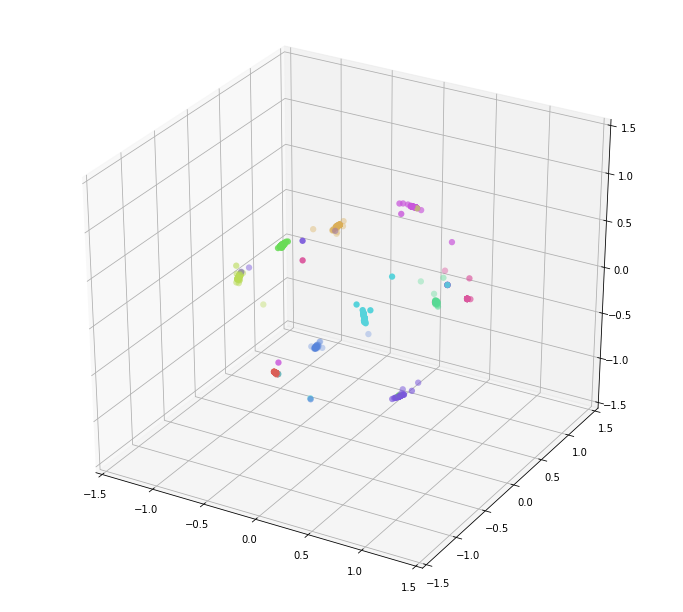

In [20]:
fig = visual(*callback(best_model))

In [19]:
torch.save(best_model.state_dict(), './saved_models/embedding{}'.format(time()))

In [20]:
best_model.eval()
for param in best_model.parameters():
    param.requires_grad = False

In [25]:
net = Net(best_model)

In [26]:
epoch = 10
loss_fun = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

In [27]:
for e in range(epoch):
    running_loss = 0
    test_loss    = 0
    best_loss    = 10
    for data, labels in train_loader:
        with autograd.detect_anomaly():
            optimizer.zero_grad()
            out  = net(data)
            loss = loss_fun(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    else:
        for data, labels in test_loader:
            out  = net(data)
            loss = loss_fun(out, labels)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        
        if test_loss < best_loss:
            best_model = deepcopy(net)
        
        print("Epoch {} - Training loss: {:.4f} - Test loss: {:.4f}".format(e, running_loss/len(train_loader), test_loss))

Epoch 0 - Training loss: 1.5030 - Test loss: 0.9872
Epoch 1 - Training loss: 0.7227 - Test loss: 0.5336
Epoch 2 - Training loss: 0.4078 - Test loss: 0.3263
Epoch 3 - Training loss: 0.2588 - Test loss: 0.2269
Epoch 4 - Training loss: 0.1874 - Test loss: 0.1819
Epoch 5 - Training loss: 0.1541 - Test loss: 0.1599
Epoch 6 - Training loss: 0.1388 - Test loss: 0.1506
Epoch 7 - Training loss: 0.1315 - Test loss: 0.1462
Epoch 8 - Training loss: 0.1278 - Test loss: 0.1439
Epoch 9 - Training loss: 0.1256 - Test loss: 0.1425


In [35]:
y_pred = torch.tensor([]).long()
good = 0
for img, labels in test_loader:
    res = torch.exp(net(img))
    predict = torch.sum(torch.eq(torch.argmax(res, dim=1), labels), dim = 0)
    good += predict.item()
good /= (len(test_loader)*32)
print(good)

0.9781349840255591
